# **Image Classification Model for Identifying Broken Phones**

This project aims to utilise a pre-trained machine learning model to predict and classify various examples of mobile phones using data called from a website via API.

Intuitive packages will be imported to streamline data gathering, function composition, computer vision tasks, automation, widget and visualisation creation and evaluation metrics.

### **Initialising packages**
Packages initialised as first step to improve efficency.

In [19]:
# Package for search engine API
!pip install duckduckgo_search
# Resource gathering and machine learning
from duckduckgo_search import DDGS
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
# Intentional environment pause
from time import sleep
# Widget for image upload
import ipywidgets as widgets
# Exploratory data analysis (EDA) tools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
# Evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

### **Image search function**
Utilises DuckDuckGo's search engine's API to locate images according to specified search terms, returning a list of URLs that points to the images.



In [20]:
def search_images(term, max_images = 50):
    print(f"Searching for '{term}'")
    return L(DDGS().images(keywords=term, max_results=max_images)).itemgot('image')

### **Download and thumbnail creation**
Downloads first search result of "broken phone" and "smart phone" and saves as .jpg file (256x256 pixel dimension).

Searching for 'broken phone'


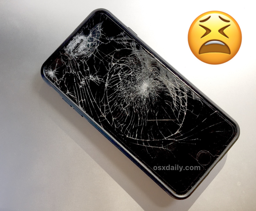

In [21]:
urls = search_images("broken phone")
dest = "broken_phone.jpg"
download_url(urls[0], dest, show_progress = True)
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'smart phone'


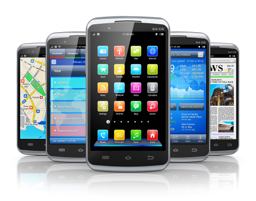

In [22]:
urls = search_images("smart phone")
dest = "phone.jpg"
download_url(urls[0], dest, show_progress = True)
im = Image.open(dest)
im.to_thumb(256,256)

### **Search for and save images**
For loop function searching for images of broken phones and smart phones, downloading them into folders and resizing images (maximum size of 400 pixels).


In [23]:
searches = "broken phone", "smart phone"
path = Path("is_my_phone_broken")

for search_term in searches:
    dest = (path/search_term)
    dest.mkdir(exist_ok = True, parents = True)
    download_images(dest, urls = search_images(f"{search_term} photo"))
    sleep(10) # intentional delay to reduce load
    resize_images(path/search_term, max_size = 400, dest= path/search_term)

Searching for 'broken phone photo'
Searching for 'smart phone photo'


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### **Verification and removal of failed images**
Handles corrupted/invalid images, removing them and returns failed images count.

In [24]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print("Number of removed images: " + str(len(failed)))

Number of removed images: 6


### **Exploratory data analysis (EDA)**
Understand data distribution, identify potential issues, guide model-building process.

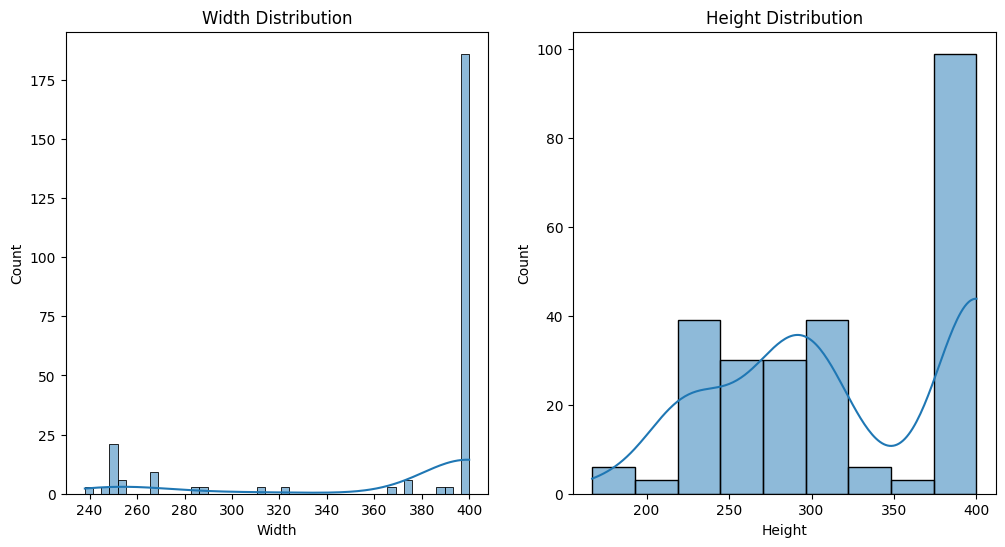

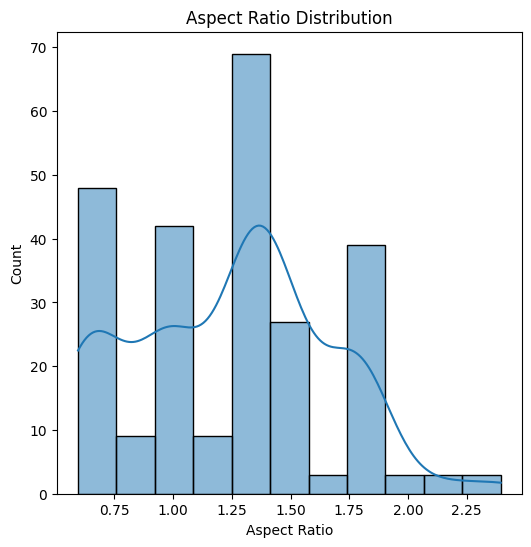

In [7]:
# Analyse image file sizes
image_files = get_image_files(path)
image_sizes = [Image.open(file).size for file in image_files]
widths, heights = zip(*image_sizes)

# Create dataframe
df = pd.DataFrame({'Width': widths, 'Height': heights})

# Plot width and height distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Width'], kde=True)
plt.title('Width Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df['Height'], kde=True)
plt.title('Height Distribution')

plt.show()

# Aspect ratio check
df['Aspect Ratio'] = df['Width'] / df['Height']
plt.figure(figsize=(6, 6))
sns.histplot(df['Aspect Ratio'], kde=True)
plt.title('Aspect Ratio Distribution')
plt.show()

### **EDA conclusions**
#### *Width*
Significant widths are at 400 pixels and very few at the rest of the distribution, this suggests a large proportion of images are standardised.
#### *Height*
Similar to width; most results contain 400 pixels but have more variance, this suggests a wider variety of heights.
#### *Aspect ratio*
A varied distribution with a peak of 1.25, this suggests that many images are more rectangular in shape, but also that there are a variety of other shapes.
#### *Overall*
A significant portion of data is standardised at 400x400 pixels, and that there are a variety of shapes (according to the aspect ratio distribution) that may influence model performance.

### **Data block creation**
Loads and processes images, defines input and output, and data split percentages, alongside resizing of images.

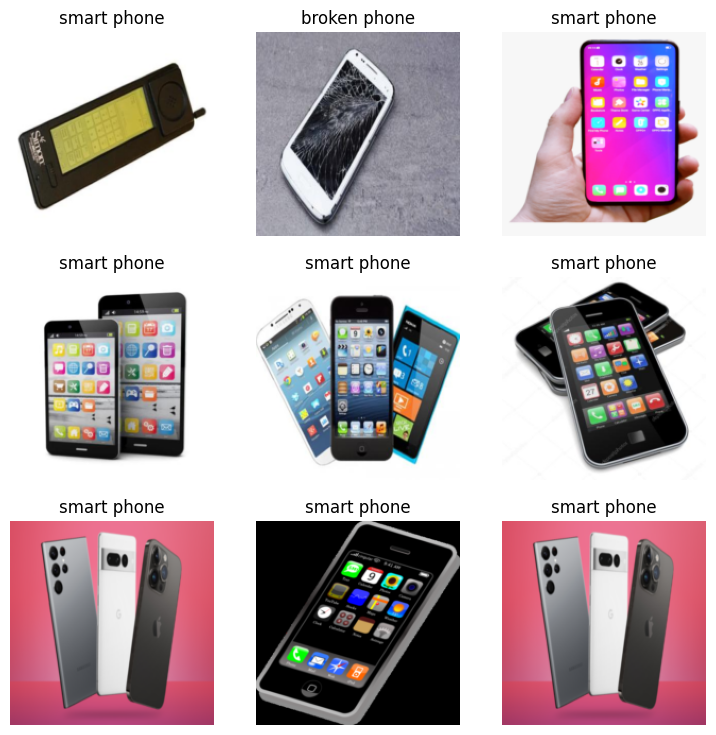

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # inputs = images, outputs = categories
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path) # dataloader feeds data in "batches" to GPU (improves training times and load)

dls.show_batch() # visualise

### **Model creation and fine-tuning**
Compare initial "resnet18" model with others to determine best fit, perform hyperparameter tuning, allowing for more optimal results.

In [9]:
# Define model comparison list
models = [resnet18, resnet34, resnet50]
model_results = {}

# Train all models
for model in models:
  print(f"Training {model.__name__}...")
  learn = vision_learner(dls, model, metrics=error_rate)
  learn.fine_tune(3)
  error_rate_value = learn.validate()[1]
  model_results[model.__name__] = error_rate_value
  print(f"{model.__name__} Error rate: {error_rate_value:.4f}\n")

# Display comparison of all model performances
print("Model performance summary:")
for model_name, error_rate_value in model_results.items():
  print(f"Model: {model_name}, Error rate: {error_rate_value:.4f}")

# Choose lowest error rate model automatically
best_model_name = min(model_results, key=model_results.get)
best_model = globals()[best_model_name]

# Output selected model
print(f"\nThe best model is: {best_model_name} with an error rate of {model_results[best_model_name]:.4f}")

Training resnet18...


epoch,train_loss,valid_loss,error_rate,time
0,1.179271,0.880952,0.294118,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.285673,0.106789,0.039216,00:53
1,0.165789,0.002911,0.000000,00:49
2,0.111087,0.002885,0.000000,00:48


resnet18 Error rate: 0.0000

Training resnet34...


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 142MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.922747,0.385124,0.196078,01:05


epoch,train_loss,valid_loss,error_rate,time
0,0.209706,0.124681,0.039216,01:30
1,0.126182,0.005072,0.000000,01:33
2,0.083798,0.002109,0.000000,01:31


resnet34 Error rate: 0.0000

Training resnet50...


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 140MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.191459,0.857100,0.294118,01:43


epoch,train_loss,valid_loss,error_rate,time
0,0.070259,0.303047,0.196078,02:19
1,0.036519,0.088616,0.058824,02:21
2,0.027384,0.014458,0.000000,02:18


resnet50 Error rate: 0.0000

Model performance summary:
Model: resnet18, Error rate: 0.0000
Model: resnet34, Error rate: 0.0000
Model: resnet50, Error rate: 0.0000

The best model is: resnet18 with an error rate of 0.0000


### **Evaluation metrics**
Quantitative measures used to assess the performance and effectiveness of the machine learning model.

In [10]:
preds, y_true = learn.get_preds()
y_pred = preds.argmax(dim=1)

precision = precision_score(y_true, y_pred, average = 'macro')
recall = recall_score(y_true, y_pred, average = 'macro')
f1 = f1_score(y_true, y_pred, average = 'macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(y_true, y_pred))

Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        23

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



### **Model performance and evaluation metrics conclusions**
#### *Model performance*
All models retained a perfect classification performance for this dataset from epoch 2 onwards, this suggests the strong suitability for this task. However, ResNet18 was chosen due to the significant efficiency compared to the rest of the models in terms of training time and computational resources. The other models will not be used as they are overkill for this task since all the error rates are the same. ResNet18 will also be less likely to overfit due to it's simpler architecture, showcasing it's optimality. It would be wise, however, to consider the factor of overfitting, as this may affect further investigations with attempting to study newly implemented data.

#### *Evaluation metrics*
A score of 1.00 across the board for all metrics indicates that the model perfectly predicts instances with no false positives or errors and no necessary trade-offs for performance. This indicates that the performance in this model is very balanced and performs well with this data, allowing for a fair conclusion of readyness for deployment. However, due to the perfect result, there may be potential overfitting occurring. This can be validated in the future via means of cross-validation or the usage of test sets, ensuring that future, unseen data generalises well.

### **Confusion matrix and loss visualisation**
Plotting confusion matrix to evaluate model's distinctions between broken and working phones, also plots top losses that indicate model's most mistakes.

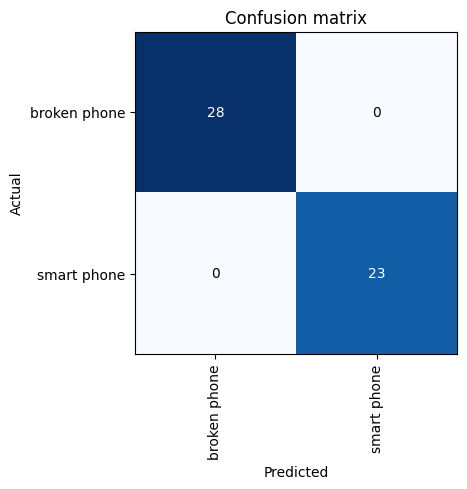

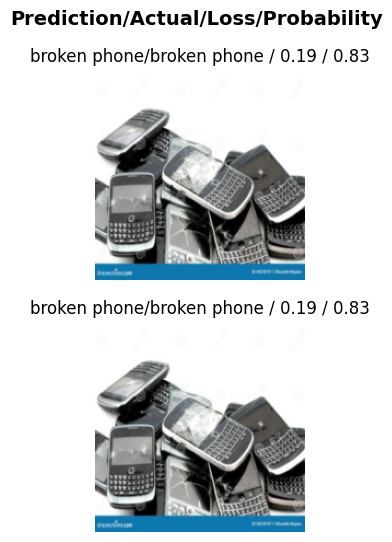

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(2, nrows=2)

### **Predictions**
Loads image, predicts using trained model and prints predicted label with probabilities for each class.

In [12]:
pred,_, probs = learn.predict(PILImage.create('phone.jpg'))
print(f"This is a: {pred}")
print(f"Probability it's a broken phone: {probs[0]:.4f}")
print(f"Probability it's not broken phone: {probs[1]:.4f}")

This is a: smart phone
Probability it's a broken phone: 0.0058
Probability it's not broken phone: 0.9942


### **Interactive image upload and prediction**
Allows user to upload image via a widget, model predicts label and prints result.

In [13]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

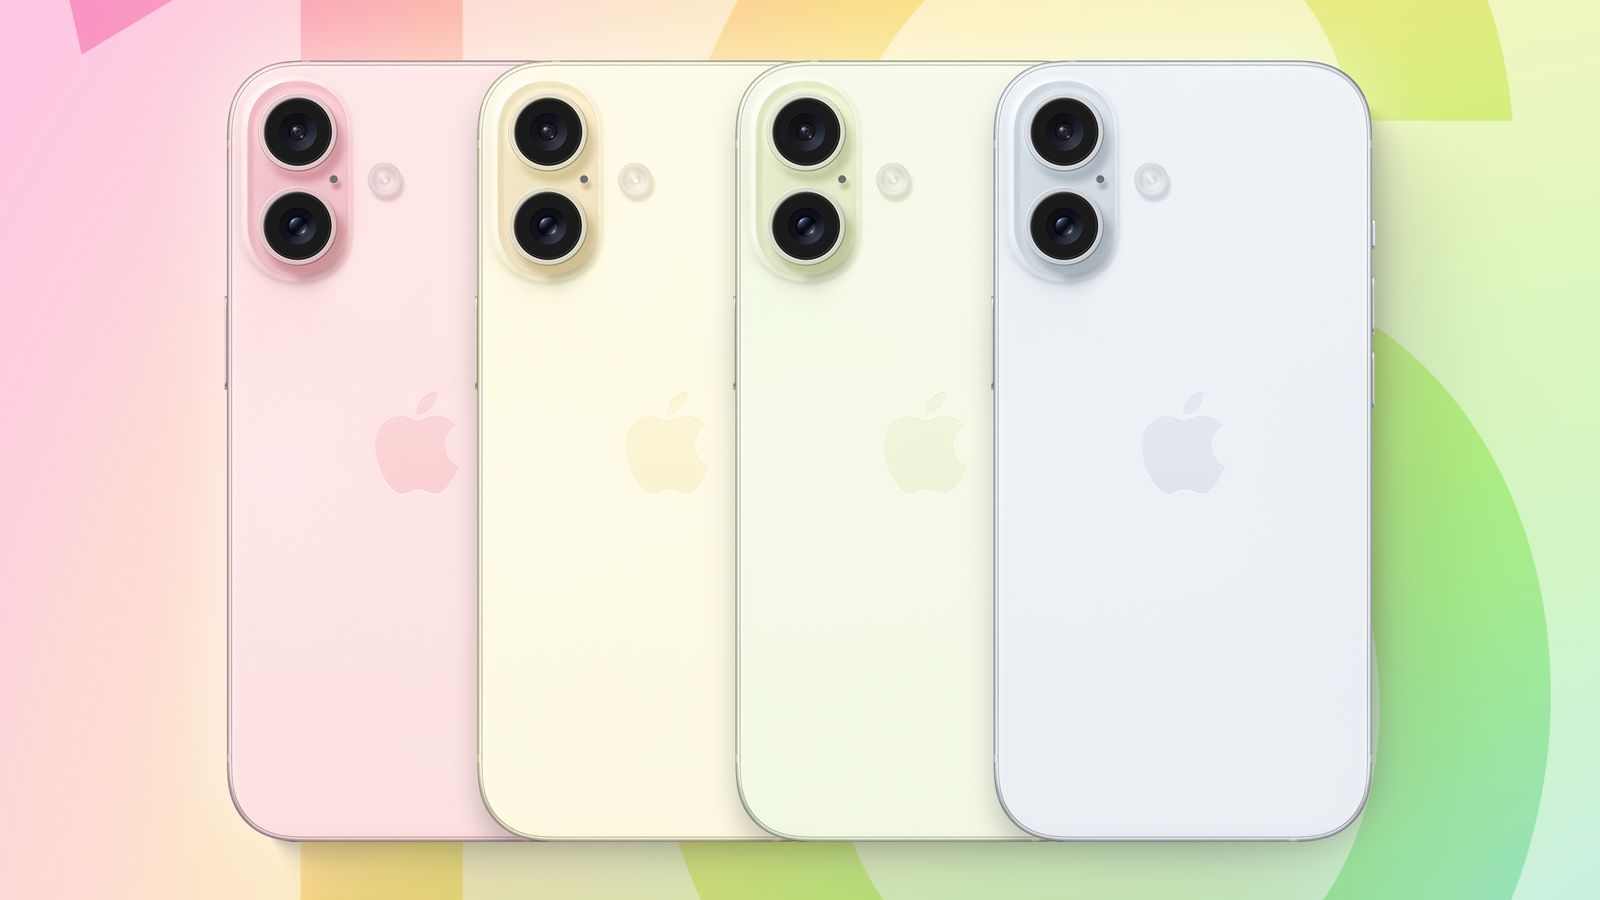

In [15]:
img = PILImage.create(btn_upload.data[-1])
img

In [16]:
pred,_,probs = learn.predict(img)
print(f"This is a {pred}")
print(f"Probability it's a broken phone: {probs[0]:.4f}")
print(f"Probability it's not broken phone: {probs[1]:.4f}")

This is a smart phone
Probability it's a broken phone: 0.0308
Probability it's not broken phone: 0.9692


# **Takeaways**
This project was a dive into a complete end-to-end process for building a machine learning model that classifies images accurately and can be used for a variety of datasets with logic tweaking. This project utilises critical steps in the data science workflow;

1. Data acquisition via API-based data gathering, allowing for ethical and efficient data collection that abides by the service's terms of use.
2. EDA of collected data to understand the data being fed into the training models and approve it's appropriateness.
3. Model training and evaluation, utilising multiple popular pre-trained models that were fine-tuned. Measures of performance for the best model were used to ensure accuracy and reliability across different classes.
4. The project pipeline was made more efficient and robust via means of automated model selection based on best-performing models.
5. Utilisation of widgets and interactive elements for potential deployment into real-world scenario, keeping the project's practicality in check.

### *Bias*
Bias can stem from a variety of factors and completely overturn results. If the trained dataset predominantly came from the same type, the model may perform worse on other sets. It is also important to consider the possibility of new data being unfair, leading to inaccurate classifications and predictions or overfitting. Instead of extracting data via an API, future projects may focus on utilising web scraping and data cleaning to allow for a more transparent set of data.

### *Ethics*
An underlooked but crucial component in the data science lifecycle would be considering ethical usage of data. By utilising an API-based approach, this ensures adherence to ethical standards by protecting the privacy of individuals and respecting terms and conditions.